google/vivit-b-16x2 <br>
https://huggingface.co/google/vivit-b-16x2 <br>
https://huggingface.co/docs/transformers/main/model_doc/vivit

# Import Library

In [1]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1


In [2]:
import torch
torch.autograd.set_detect_anomaly(True)

print('pytorch version', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))

pytorch version 2.5.1+cu121
GPU available: 1


In [3]:
#!nvcc --version

In [4]:
# For data augmentation
from torchvision import transforms

In [5]:
#!pip install -q transformers==4.35.0

In [6]:
import transformers

# For Tokenizers
from transformers import VivitImageProcessor, VivitConfig

# For Model
from transformers import VivitModel, VivitForVideoClassification

# For TPU
from transformers import set_seed
from torch.optim import AdamW

In [7]:
!pip install -q datasets #==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [8]:
# For Data Loaders
import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [9]:
#!pip install -q accelerate==0.21.0

In [10]:
# For Display
from tqdm.notebook import tqdm

# For GPU
from accelerate import Accelerator, notebook_launcher

In [11]:
!pip install -q decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 90.3 MB/s eta 0:00:00


In [12]:
# Use PyTorch bridge for Decord
import decord

from decord.bridge import set_bridge
decord.bridge.set_bridge("torch")

from decord import VideoReader

In [13]:
#!pip install -q av

In [14]:
#import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import PIL
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [16]:
# installing MediaPipe
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 57.1 MB/s eta 0:00:00


In [17]:
#pose_landmark_model = !wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
#hand_landmark_model = !wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [18]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

In [19]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
mp_face = mp.solutions.face_mesh
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [22]:
gdrive_path = '/content/drive/MyDrive/Kaggle/SignLanguage'
local_path = '/content/SignLanguage'

In [23]:
hand_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/hand_landmarker.task'
pose_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/pose_landmarker.task'

In [24]:
BATCH_SIZE = 8
print('BATCH_SIZE =',BATCH_SIZE)

BUFFER_SIZE = BATCH_SIZE * 8
print('BUFFER_SIZE =',BUFFER_SIZE)

MODEL_TRANSFORMER = 'google/vivit-b-16x2'

FRAME_STEPS = 4
print('FRAME_STEPS =',FRAME_STEPS)

CLIP_LENGTH = 32 # MTech project was with CLIP_LENGTH = 85, CLIP_LENGTH of model = 32
print('CLIP_LENGTH =',CLIP_LENGTH)

CLIP_HEIGHT = 640
CLIP_WIDTH = 480
print('Image Dimension =', CLIP_WIDTH,'X', CLIP_HEIGHT)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

BATCH_SIZE = 8
BUFFER_SIZE = 64
FRAME_STEPS = 4
CLIP_LENGTH = 32
Image Dimension = 480 X 640
Image Dimension = 224 X 224


In [25]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [26]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [27]:
seed_everything(42)

# Import Data

In [28]:
data_dir = f'{gdrive_path}/Data'
print(data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/Data


In [29]:
# Copy videos from Google Drive to local disk for faster loading during training
if not os.path.exists(local_path):
    shutil.copytree(data_dir, local_path)

print("Videos copied to local disk.")

Videos copied to local disk.


In [30]:
print(local_path)

/content/SignLanguage


In [31]:
classes = sorted(os.listdir(local_path))
print(classes)

['beautiful', 'happy', 'sad', 'ugly']


In [32]:
label_to_idx = {}
idx_to_label = {}

for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  if os.path.exists(local_path):
    label_to_idx[label] = idx
    idx_to_label[idx] = label

In [33]:
print(label_to_idx)

{'beautiful': 0, 'happy': 1, 'sad': 2, 'ugly': 3}


In [34]:
print(idx_to_label)

{0: 'beautiful', 1: 'happy', 2: 'sad', 3: 'ugly'}


In [35]:
# Collect all video files
video_path = []
labels_int = []
labels_text = []
for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  #print(class_folder)
  video_file = glob(os.path.join(class_folder, '*.MOV'))
  #print(video_file)
  video_path.extend(video_file)
  labels_int.extend([idx] * len(video_file))
  labels_text.extend([label] * len(video_file))

In [36]:
print('input path size:', len(video_path))
print(video_path)

input path size: 46
['/content/SignLanguage/beautiful/MVI_9570.MOV', '/content/SignLanguage/beautiful/MVI_9573.MOV', '/content/SignLanguage/beautiful/MVI_9725.MOV', '/content/SignLanguage/beautiful/MVI_9572.MOV', '/content/SignLanguage/beautiful/MVI_9726.MOV', '/content/SignLanguage/beautiful/MVI_9569.MOV', '/content/SignLanguage/beautiful/MVI_9723.MOV', '/content/SignLanguage/beautiful/MVI_9724.MOV', '/content/SignLanguage/beautiful/MVI_9571.MOV', '/content/SignLanguage/happy/MVI_5342.MOV', '/content/SignLanguage/happy/MVI_5341.MOV', '/content/SignLanguage/happy/MVI_5343.MOV', '/content/SignLanguage/happy/MVI_9295.MOV', '/content/SignLanguage/happy/MVI_5183.MOV', '/content/SignLanguage/happy/MVI_9297.MOV', '/content/SignLanguage/happy/MVI_9542.MOV', '/content/SignLanguage/happy/MVI_9375.MOV', '/content/SignLanguage/happy/MVI_9296.MOV', '/content/SignLanguage/happy/MVI_5185.MOV', '/content/SignLanguage/happy/MVI_9540.MOV', '/content/SignLanguage/happy/MVI_5184.MOV', '/content/SignLangu

In [37]:
print('labels size:', len(labels_int))
print(labels_int)

labels size: 46
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]


In [38]:
print('labels size:', len(labels_text))
print(labels_text)

labels size: 46
['beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'ugly', 'ugly', 'ugly', 'ugly', 'ugly', 'ugly', 'ugly', 'ugly']


# Train Test Split

In [39]:
train_path, val_path, train_label, val_label = train_test_split(video_path, labels_int, test_size=0.2, stratify=labels_text, random_state=42)
#train_path, test_path, train_label, test_label = train_test_split(train_path, train_label, test_size=0.2, stratify=train_label, random_state=42)

In [40]:
print('Train data size:',len(train_path))
print('Val data size:',len(val_path))
#print('Test data size:',len(test_path))

Train data size: 36
Val data size: 10


In [41]:
train_label[:5]

[1, 1, 0, 1, 2]

# Create MP Objects

In [42]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
#FaceLandmarker = mp.tasks.vision.FaceLandmarker
#FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the video mode:
options_hand = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path = hand_model_path),
    running_mode=VisionRunningMode.VIDEO)

# Create a pose landmarker instance with the video mode:
options_pose = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=pose_model_path),
    running_mode=VisionRunningMode.VIDEO)

## Create a face landmarker instance with the video mode:
#options_face = FaceLandmarkerOptions(
#    base_options=BaseOptions(model_asset_path=face_model_path),
#    running_mode=VisionRunningMode.VIDEO)

#detector_face = vision.FaceLandmarker.create_from_options(options_face)
detector_hand = vision.HandLandmarker.create_from_options(options_hand)
detector_pose = vision.PoseLandmarker.create_from_options(options_pose)

In [43]:
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    enable_segmentation=False,
    refine_face_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
    )

# Validating the input data

In [44]:
idx = 2
train_path[idx]

'/content/SignLanguage/beautiful/MVI_9571.MOV'

In [45]:
vr_demo = VideoReader(train_path[idx])#, width=CLIP_WIDTH, height=CLIP_HEIGHT)

In [46]:
print('Number of Fames in the video:',len(vr_demo))

Number of Fames in the video: 64


In [47]:
frame = vr_demo[1]
print('Shape of the frame:',frame.shape)

Shape of the frame: torch.Size([1080, 1920, 3])


In [48]:
key_indices = vr_demo.get_key_indices()
key_frames = vr_demo.get_batch(key_indices)
print(key_frames.shape)

torch.Size([6, 1080, 1920, 3])


In [49]:
print(key_frames.permute(0, 3, 1, 2).shape)

torch.Size([6, 3, 1080, 1920])


In [50]:
image_processor_demo = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER,
                                                           size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT},
                                                           crop_size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT}
                                                           )

preprocessor_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

In [51]:
model_inputs_demo = image_processor_demo.preprocess(videos=list(key_frames),
                                               return_tensors='pt',
                                               input_data_format='channels_last', # image in (height, width, num_channels) format.
                                               )

In [52]:
print(model_inputs_demo.pixel_values.shape)

torch.Size([1, 6, 3, 640, 480])


In [53]:
reshaped_video = model_inputs_demo.pixel_values[0].permute(0, 2, 3, 1)

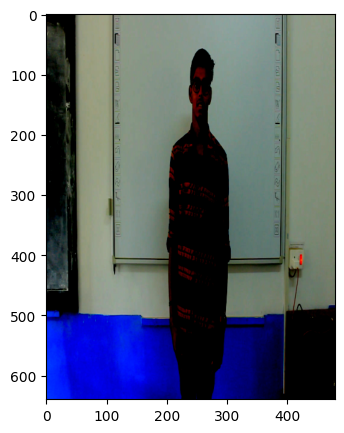

In [54]:
plt.imshow(reshaped_video[0])

In [55]:
# Define a sample transformation pipeline
transform_demo = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(size=(640, 480), scale=(0.5, 1)),  # Zoom and crop # (1080, 1920)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

In [56]:
selected_video = model_inputs_demo.pixel_values[0]
print(len(selected_video))
print(selected_video.shape)

6
torch.Size([6, 3, 640, 480])


In [57]:
print(len(reshaped_video))
print(reshaped_video.shape)

6
torch.Size([6, 640, 480, 3])


In [58]:
# Process each frame
augmented_frames = []
for i in range(0, len(vr_demo), 5):
    frame_np = torch.Tensor.numpy(vr_demo[i]) # Convert frame to numpy
    pil_image = PIL.Image.fromarray(frame_np)
    frame = transform_demo(pil_image)  # Apply transformations
    augmented_frames.append(frame)
augmented_frames = torch.stack(augmented_frames)

In [59]:
augmented_frames.shape

torch.Size([13, 3, 640, 480])

In [60]:
ch_aug_frame = augmented_frames[10].permute(1, 2, 0)

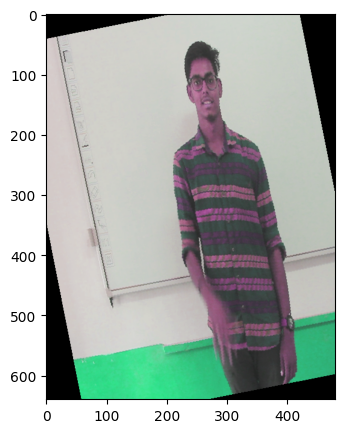

In [61]:
plt.imshow(ch_aug_frame)

In [62]:
#model_inputs_demo

# Load Image

In [63]:
'''
# Load the input Video
#cap = cv2.VideoCapture('/content/drive/MyDrive/Mtech_Project/Dataset_Video/MVI_9855.MOV')
cap = cv2.VideoCapture(train_path[idx])

fps = cap.get(cv2.CAP_PROP_FPS)
print('frames per second =',fps)

## Conversion

while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      break

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # results = hands.process(image)
    # results = detector_vid.detect(image)
    results = holistic.process(image)

    # Draw the  annotations on the image.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #if results.segmentation_mask:
    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_hands.HAND_CONNECTIONS,
        landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
        connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
        )
    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_hands.HAND_CONNECTIONS,
        landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
        connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
        )
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style(),
        #connection_drawing_spec = None
        )
    #mp_drawing.draw_landmarks(
    #    image,
    #    results.face_landmarks,
    #    mp_holistic.FACEMESH_CONTOURS,
    #    landmark_drawing_spec = None,
    #    connection_drawing_spec = mp_drawing_styles.get_default_face_mesh_contours_style()
    #    )

    # Flip the image horizontally for a selfie-view display.
    cv2_imshow(cv2.flip(image, 1))

    #if cv2.waitKey(5) & 0xFF == ord('r'):
    #  break

cap.release()
cv2.destroyAllWindows()
'''

'\n# Load the input Video\n#cap = cv2.VideoCapture(\'/content/drive/MyDrive/Mtech_Project/Dataset_Video/MVI_9855.MOV\')\ncap = cv2.VideoCapture(train_path[idx])\n\nfps = cap.get(cv2.CAP_PROP_FPS)\nprint(\'frames per second =\',fps)\n\n## Conversion\n\nwhile cap.isOpened():\n    success, image = cap.read()\n    if not success:\n      print("Ignoring empty camera frame.")\n      # If loading a video, use \'break\' instead of \'continue\'.\n      break\n\n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    # results = hands.process(image)\n    # results = detector_vid.detect(image)\n    results = holistic.process(image)\n\n    # Draw the  annotations on the image.\n    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)\n    #if results.segmentation_mask:\n    mp_drawing.draw_landmarks(\n        image,\n        results.left_hand_landmarks,\n        mp_hands.HAND_CONNECTIONS,\n        landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),\n        connection_drawing_s

# Create Dataset

In [64]:
# Define Image Processor
#image_processor = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER)
image_processor = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER,
                                                      size={'width':CLIP_SIZE, 'height':CLIP_SIZE},
                                                      crop_size={'width':CLIP_SIZE, 'height':CLIP_SIZE})

In [65]:
# Define a sample transformation pipeline
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(size=(CLIP_SIZE, CLIP_SIZE), scale=(0.1, 1)),  # Zoom and crop, changing it to square as the model only takes sq inputs
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(30),
    transforms.ToTensor()
])


In [66]:
class CustomDataset(Dataset):
    def __init__(self, pixel_values, labels):
        self.labels = labels
        self.pixel_values = pixel_values

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'labels': self.labels[idx],
            'pixel_values': self.pixel_values[idx],
        }
        return item

In [67]:
class CreateDataset():
    def __init__(self, image_processor
                , clip_len
                , frame_step
                , transform
                ):
        super().__init__()
        self.image_processor = image_processor
        self.clip_len = clip_len
        self.transform = transform
        self.frame_step = frame_step

    def read_video(self, video_path):
        # Read the video and convert to frames
        vr = VideoReader(video_path)
        total_frames = len(vr)

        # If number of frames are less than clip_len
        if total_frames < self.clip_len:
            key_indices = list(range(total_frames)) # Get all frames
            for i in range(self.clip_len - len(key_indices)): # Append additional frames if necessary
                key_indices.append(key_indices[-1])

        elif (total_frames >= self.clip_len) & (total_frames < self.clip_len*2):
            key_indices = list(range(0, total_frames, 2)) # Get alternate frames
            for i in range(self.clip_len - len(key_indices)): # Append additional frames if necessary
                key_indices.append(key_indices[-1])

        elif (total_frames >= self.clip_len*2) & (total_frames < self.clip_len*3):
            key_indices = list(range(0, total_frames, 3)) # Get alternate frames
            for i in range(self.clip_len - len(key_indices)): # Append additional frames if necessary
                key_indices.append(key_indices[-1])

        else:
            key_indices = list(range(0, total_frames, 4))
            for i in range(self.clip_len - len(key_indices)): # Append additional frames if necessary
                key_indices.append(key_indices[-1])

        # Get only required number of frames
        key_indices = key_indices[:self.clip_len]

        #load frames
        frames = vr.get_batch(key_indices)

        # All transformations accept PIL Image
        # Tensor Image is a tensor with (B, H, W, C) shape, B=batch_size, C=channels, H=Height and W=width

        return frames #.permute(0, 3, 1, 2)

    def data_augmentation(self, video):
        augmented_frames=[]
        for frame in video:
            frame = frame.permute(1, 2, 0)
            frame = self.transform(PIL.Image.fromarray(torch.Tensor.numpy(frame)))  # Convert to numpy and then to PIL image and apply transformations
            augmented_frames.append(frame)
        augmented_frames = torch.stack(augmented_frames)
        return augmented_frames

    def data_prep_validation(self, video):
        augmented_frames = self.image_processor.preprocess(list(video),
                                                            return_tensors="pt",
                                                            #input_data_format='channels_last'
                                                            ) # image in (height, width, num_channels) format.
        return augmented_frames


    def add_landmarks(self, video):
        annotated_image = []
        for frame in video:
            #image_np = frame.permute(1, 2, 0).numpy()
            image_np = frame.numpy()
            image = (image_np * 255).astype(np.uint8)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style(),
                #connection_drawing_spec = None
                )

            #image = (image / 255).astype(np.float32)
            #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            image = torch.from_numpy(image).permute(2, 0, 1)
            annotated_image.append(image)

        annotated_image = torch.stack(annotated_image)
        #annotated_image = torch.from_numpy(np.array(annotated_image))
        return annotated_image

    def create_dataset(self, video_paths, labels, training=True):
        pixel_values = []
        for path in video_paths:
            # Read and process Videos
            video = self.read_video(path)
            annotated_video = self.add_landmarks(video)

            if training:
                # Data Preperation for ML model with Augmentation
                processed_video = self.data_augmentation(annotated_video)
                #annotated_video = self.add_landmarks(processed_video)
                pixel_values.append(processed_video)
            else:
                # Data Preperation for ML Model
                processed_video = self.data_prep_validation(annotated_video)
                #annotated_video = self.add_landmarks(processed_video['pixel_values'].squeeze(0))
                pixel_values.append(processed_video['pixel_values'].squeeze(0))

        #labels = torch.from_numpy(np.array(labels))
        labels = torch.tensor(labels, dtype=torch.int64)

        return CustomDataset(pixel_values=pixel_values,
                             labels=labels)

In [68]:
dataset_obj = CreateDataset(image_processor, CLIP_LENGTH, FRAME_STEPS, transform) #, CLIP_WIDTH, CLIP_HEIGHT)

# Testing the custome image processing class

## Stage 1 = read_video

In [69]:
sample_frames = dataset_obj.read_video(train_path[0])

In [70]:
print(sample_frames.shape)

torch.Size([32, 1080, 1920, 3])


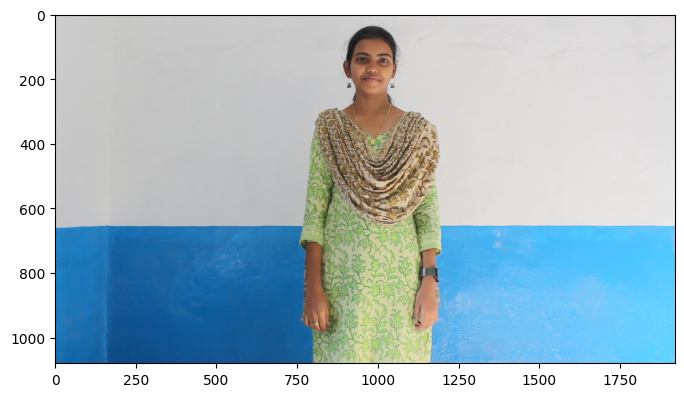

In [71]:
plt.imshow(sample_frames[0])

## Stage 2 = add_landmarks

In [72]:
sample_landmarked_frames = dataset_obj.add_landmarks(sample_frames)

In [73]:
print(sample_landmarked_frames.shape)

torch.Size([32, 3, 1080, 1920])


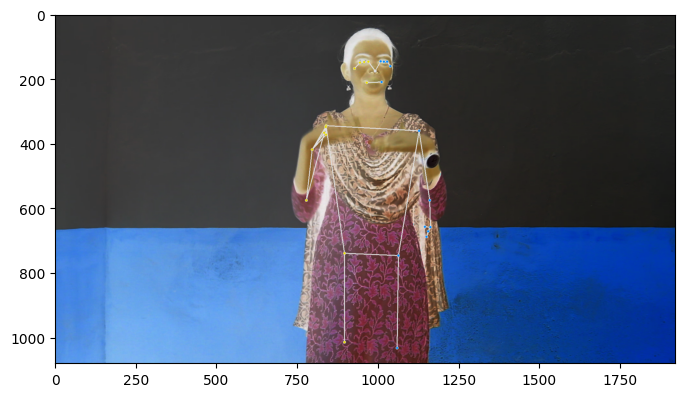

In [74]:
sample_landmarked_frames_sc = (sample_landmarked_frames / 255)
plt.imshow(sample_landmarked_frames_sc[10].permute(1, 2, 0))

## Stage 3 = Data Annotation

In [75]:
sample_annotated_frames = dataset_obj.data_augmentation(sample_landmarked_frames)

In [76]:
print(sample_annotated_frames.shape)

torch.Size([32, 3, 224, 224])


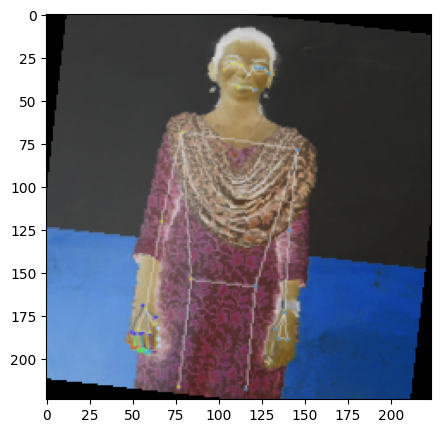

In [77]:
plt.imshow(sample_annotated_frames[0].permute(1, 2, 0))

## Stage 4 = Data Preprocessing

In [78]:
sample_annotated_frames = dataset_obj.data_prep_validation(sample_landmarked_frames)

In [79]:
print(sample_annotated_frames['pixel_values'].shape)

torch.Size([1, 32, 3, 224, 224])


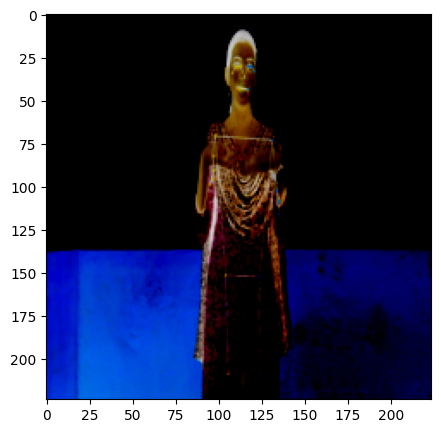

In [80]:
plt.imshow(sample_annotated_frames['pixel_values'].squeeze(0)[7].permute(1, 2, 0))

## Stage 5 = Complete setup

In [81]:
train_ds = dataset_obj.create_dataset(train_path, train_label, training=True)
val_ds = dataset_obj.create_dataset(val_path, val_label, training=False)
#test_ds = dataset_obj.create_dataset(test_path, test_label)

In [82]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
#test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [83]:
inputs = next(iter(train_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)

torch.Size([8, 32, 3, 224, 224]) torch.Size([8])


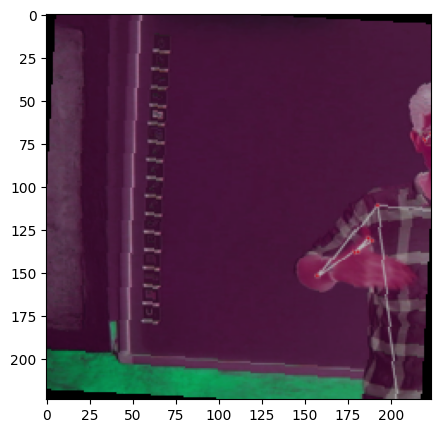

In [84]:
plt.imshow(inputs['pixel_values'][0,9].permute(1, 2, 0))

In [85]:
# Example usage
inputs = next(iter(val_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)

torch.Size([8, 32, 3, 224, 224]) torch.Size([8])


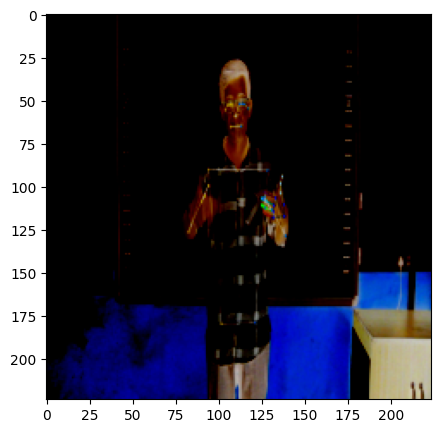

In [86]:
plt.imshow(inputs['pixel_values'][0,7].permute(1, 2, 0))

# Model Training

In [ ]:
#config_demo = VivitConfig.from_pretrained(MODEL_TRANSFORMER, id2label=idx_to_label)
#model_transformer = VivitForVideoClassification.from_pretrained(MODEL_TRANSFORMER, return_dict=True)

In [87]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 5, # early stopping
    "output_dir_pt": f"{gdrive_path}/vivit_pytorch_GPU_2",
    "output_dir_transformer": f"{gdrive_path}/vivit_pytorch_transformer_GPU_2",
    "use_tpu": False,
    'dropout_rate': 0.2
}


In [92]:
# Now we train the model
def training_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)
    accelerator.print

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Instantiate the model, chnage the final classification layer, let Accelerate handle the device placement.
    config = VivitConfig.from_pretrained(MODEL_TRANSFORMER, id2label=idx_to_label,
                                         label2id=label_to_idx, num_labels=len(classes),
                                         return_dict=True, hidden_dropout_prob=hyperparameters['dropout_rate'],
                                         attention_probs_dropout_prob=hyperparameters['dropout_rate'],
                                         image_size=CLIP_SIZE,
                                         num_frames=CLIP_LENGTH,
                                         #num_attention_heads=2,
                                         #num_hidden_layers=2
                                         )
    model_transformer = VivitForVideoClassification.from_pretrained(MODEL_TRANSFORMER, config=config, ignore_mismatched_sizes=True) # MODEL_TRANSFORMER

    # Freeze the backbone
    #for param in model_transformer.vivit.parameters():
    #  param.requires_grad = False

    model_transformer.classifier = torch.nn.Linear(model_transformer.config.hidden_size, len(classes))

    #torch.nn.init.xavier_uniform_(model_transformer.classifier.weight)
    #torch.nn.init.zeros_(model_transformer.classifier.bias)

    model_transformer.gradient_checkpointing_enable()

    # Loss function
    #criterion = torch.nn.CrossEntropyLoss()

    # Instantiate optimizer
    optimizer = AdamW(model_transformer.parameters(), lr=hyperparameters["learning_rate"])

    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.0001
    )

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_optimizer, acclerated_train_dl, acclerated_val_dl = accelerator.prepare(model_transformer, optimizer, train_dl, val_dl)

    # Build the training loop
    epochs_no_improve = 0
    min_val_loss = float("inf")

    for epoch in range(hyperparameters["num_epochs"]):
      # We only enable the progress bar on the main process to avoid having 8 progress bars.
      progress_bar = tqdm(range(len(acclerated_train_dl)), disable=not accelerator.is_main_process)
      progress_bar.set_description(f"Epoch: {epoch}")
      accelerated_model.train()
      training_loss = []
      for batch in acclerated_train_dl:

          # Forward pass
          outputs = accelerated_model(**batch)
          train_logits = outputs.logits

          # Labels
          train_labels = batch['labels']
          #train_loss = criterion(train_logits, train_labels)
          train_loss = torch.nn.functional.cross_entropy(input=train_logits, target=train_labels)

          # Backward pass
          accelerator.backward(train_loss)

          # Optimize
          acclerated_optimizer.step()
          acclerated_optimizer.zero_grad()

          # We gather the loss from the 8 TPU cores to have them all.
          training_loss.append(accelerator.gather(train_loss[None]))
          progress_bar.set_postfix({'loss': train_loss.item()})
          progress_bar.update(1)

      # Compute average training loss
      training_loss_final = torch.stack(training_loss).sum().item() / len(training_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: learning rate:", scheduler.get_last_lr())
      accelerator.print(f"epoch {epoch}: training loss:", training_loss_final)

      # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
      accelerated_model.eval()
      validation_loss = []

      for batch in acclerated_val_dl:
          with torch.no_grad():
              outputs = accelerated_model(**batch)

          val_logits = outputs.logits
          val_labels = batch['labels']

          #val_loss = criterion(val_logits, val_labels)
          val_loss = torch.nn.functional.cross_entropy(input=val_logits, target=val_labels)

          # We gather the loss from the 8 TPU cores to have them all.
          validation_loss.append(accelerator.gather(val_loss[None]))

      # Compute average validation loss
      validation_loss_final = torch.stack(validation_loss).sum().item() / len(validation_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: validation loss:", validation_loss_final)

      # Step the scheduler
      scheduler.step(validation_loss_final)

      # Save model with early stopping
      if validation_loss_final < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = validation_loss_final
          # Save the entire model (including architecture and weights)
          torch.save(accelerated_model, hyperparameters['output_dir_pt'])
          accelerated_model.save_pretrained(hyperparameters['output_dir_transformer'])
          continue
      else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == hyperparameters["patience"]:
          accelerator.print("Early stopping!")
          break

In [93]:
training_function()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vivit-b-16x2/snapshots/fc341053d36b42d446b3ffccdbd52452712a23f3/config.json
Model config VivitConfig {
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.2,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "id2label": {
    "0": "beautiful",
    "1": "happy",
    "2": "sad",
    "3": "ugly"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "beautiful": 0,
    "happy": 1,
    "sad": 2,
    "ugly": 3
  },
  "layer_norm_eps": 1e-06,
  "model_type": "vivit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 32,
  "num_hidden_layers": 12,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.47.1",
  "tubelet_size": [
    2,
    16,
    16
  ]
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hu

  0%|          | 0/5 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

epoch 0: learning rate: [0.0001]
epoch 0: training loss: 1.2038811683654784
epoch 0: validation loss: 1.2410444021224976


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/model.safetensors


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1: learning rate: [0.0001]
epoch 1: training loss: 0.9454668045043946
epoch 1: validation loss: 1.0761759281158447


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/model.safetensors


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 2: learning rate: [0.0001]
epoch 2: training loss: 0.9161832809448243
epoch 2: validation loss: 1.0975801944732666


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 3: learning rate: [0.0001]
epoch 3: training loss: 0.6829107761383056
epoch 3: validation loss: 0.9611868262290955


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/model.safetensors


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 4: learning rate: [0.0001]
epoch 4: training loss: 0.6964604377746582
epoch 4: validation loss: 0.9483709335327148


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/model.safetensors


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 5: learning rate: [0.0001]
epoch 5: training loss: 0.646477222442627
epoch 5: validation loss: 0.8824995756149292


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/model.safetensors


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 6: learning rate: [0.0001]
epoch 6: training loss: 0.5158016204833984
epoch 6: validation loss: 0.8818396925926208


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/model.safetensors


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 7: learning rate: [0.0001]
epoch 7: training loss: 0.6133642673492432
epoch 7: validation loss: 0.8959918022155762


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 8: learning rate: [0.0001]
epoch 8: training loss: 0.6575970649719238
epoch 8: validation loss: 0.9116668701171875


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 9: learning rate: [0.0001]
epoch 9: training loss: 0.6732241630554199
epoch 9: validation loss: 0.916022539138794


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 10: learning rate: [0.0001]
epoch 10: training loss: 0.552858543395996
epoch 10: validation loss: 0.8798483610153198


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_2/model.safetensors


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 11: learning rate: [0.0001]
epoch 11: training loss: 0.5089357376098633
epoch 11: validation loss: 0.8986575603485107


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 12: learning rate: [0.0001]
epoch 12: training loss: 0.49823646545410155
epoch 12: validation loss: 0.8871225118637085


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 13: learning rate: [0.0001]
epoch 13: training loss: 0.40800652503967283
epoch 13: validation loss: 0.9929916858673096


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 14: learning rate: [0.0001]
epoch 14: training loss: 0.240693998336792
epoch 14: validation loss: 1.1266820430755615


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load model

In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 5, # early stopping
    "output_dir_pt": f"{gdrive_path}/vivit_pytorch_GPU_2",
    "output_dir_transformer": f"{gdrive_path}/vivit_pytorch_transformer_GPU_2",
    "use_tpu": False,
    'dropout_rate': 0.2
}

In [ ]:
model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer'])
model_pretrained.eval()
print("Entire model loaded successfully!")

In [ ]:
image_processor_prod = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER)

In [ ]:
#model_pretrained = torch.load(hyperparameters['output_dir'], map_location=torch.device('cpu'))
#model_pretrained.eval()
#print("Entire model loaded successfully!")

# Model testing

In [ ]:
class CustomDatasetProd(Dataset):
    def __init__(self, pixel_values): #labels
        self.pixel_values = pixel_values
        #self.labels = labels

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx].squeeze(0),
            #'labels': self.labels[idx]
        }
        return item

In [ ]:
class CreateDatasetProd():
    def __init__(self, image_processor,
                clip_len, # clip_width=-1, clip_height=-1,
                frame_step
                #, transform=None
                ):
        super().__init__()
        #self.video_paths = video_paths
        #self.labels = labels
        self.image_processor = image_processor

        self.clip_len = clip_len
        #self.clip_width = clip_width
        #self.clip_height = clip_height

        #self.transform = transform
        self.frame_step = frame_step

    def read_video(self, video_path):
        #vr = VideoReader(video_path, ctx=gpu())#, width=self.clip_width, height=self.clip_height) # For GPU
        vr = VideoReader(video_path) #, ctx=cpu(), width=self.clip_width, height=self.clip_height) # For CPU
        total_frames = len(vr)
        #key_indices = vr.get_key_indices()
        key_indices = list(range(0, total_frames, self.frame_step))
        #print(key_indices)

        # Check if you have sufficient frames
        if len(key_indices) < self.clip_len:
          # if number of selected frames are low
          for i in range(0, self.clip_len - len(key_indices) , 1):
            key_indices.append(key_indices[-1])
        else:
          # if number of selected frames are high
          key_indices = key_indices[:self.clip_len]
        #print(key_indices)

        #load frames
        frames = vr.get_batch(key_indices)
        #print(frames.shape)

        # All transformations accept PIL Image
        # Tensor Image is a tensor with (B, C, H, W) shape, B=batch_size, C=channels, H=Height and W=width

        return frames #.permute(0, 3, 1, 2)

    def create_dataset(self, video_paths):
        #input_ids, attention_mask = [], []
        pixel_values = []
        for path in video_paths:
            # Read and process Videos
            video = self.read_video(path)
            # prepare video for the model
            inputs = self.image_processor.preprocess(list(video), return_tensors="pt",
                                                      input_data_format='channels_last') # image in (height, width, num_channels) format.
            #input_ids.append(inputs['input_ids'].squeeze(0))
            #attention_mask.append(inputs['attention_mask'].squeeze(0))
            pixel_values.append(inputs['pixel_values'].squeeze(0))
            #pixel_val = inputs['pixel_values'].squeeze(1)
            #print(np.array(attention_mask).shape)

        return CustomDatasetProd(#input_ids=input_ids,
                             #attention_mask=attention_mask,
                             pixel_values=pixel_values
                             )

In [ ]:
dataset_prod_obj = CreateDatasetProd(image_processor_prod,CLIP_LENGTH, FRAME_STEPS)

In [ ]:
prod_ds = dataset_prod_obj.create_dataset(test_path)

In [ ]:
prod_dl = DataLoader(prod_ds, batch_size=BATCH_SIZE)

In [ ]:
prod_inputs = next(iter(prod_dl))
print(prod_inputs['pixel_values'].shape) #prod_inputs['input_ids'].shape, prod_inputs['attention_mask'].shape, np.array(prod_inputs['labels']).shape

In [ ]:
predicted_label = []
for batch in prod_dl:
  with torch.no_grad():
    outputs = model_pretrained(**batch)
    logits = outputs.logits
  predicted_label.append(logits.argmax(-1))
predicted_label = torch.cat(predicted_label)

In [ ]:
print(test_label)

In [ ]:
print(predicted_label)

In [ ]:
print(classification_report(test_label,predicted_label))